In [ ]:
from google.colab import drive, auth
import sys
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import librosa
import matplotlib.pyplot as plt
import csv
from IPython.display import Audio

#sklearn libraries
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#tensorflow for modles
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Conv2D, MaxPooling2D, Flatten, concatenate, Reshape, BatchNormalization
import tensorflow_hub as hub
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback,EarlyStopping
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

In [ ]:
#declare sampling rate
sampling_rate = 16000

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read data
bird_df = pd.read_csv('/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/notebooks/RG/3_species/train_val.csv')
bird_df.head(1)

,primary_label,filename,type,filename_npy,rating,duration_secs_32000,country,continent,data
0,eaywag1,eaywag1/XC718442.ogg,blank,eaywag1/XC718442.npy,good,12.538781,FR,EUROPE,train


In [ ]:
#Gather the training data from the main dataset
bird_train_df = bird_df[bird_df['data'] == 'train']
bird_train_df.shape

(657, 9)

In [ ]:
#count the number of species
species_counts = bird_train_df['primary_label'].value_counts()
print(species_counts)

comsan     244
eaywag1    216
barswa     197
Name: primary_label, dtype: int64


In [ ]:
#lets create a separate validation set
bird_val_df =  bird_df[bird_df['data'] == 'val']
bird_val_df.shape

(283, 9)

In [ ]:
# Group the dataframe by the "primary_label" column and calculate the total duration for each group
label_durations_train = bird_train_df.groupby('primary_label')['duration_secs_32000'].sum()

# Print the result
print(label_durations_train)


# Group the dataframe by the "primary_label" column and calculate the total duration for each group
label_durations_val = bird_val_df.groupby('primary_label')['duration_secs_32000'].sum()

# Print the result
print(label_durations_val)

primary_label
barswa     7418.617906
comsan     7488.164156
eaywag1    7235.116813
Name: duration_secs_32000, dtype: float64
primary_label
barswa     2956.129906
comsan     2823.414500
eaywag1    3083.174312
Name: duration_secs_32000, dtype: float64


In [ ]:
train_class_counts = bird_train_df['primary_label'].value_counts()
val_class_counts = bird_val_df['primary_label'].value_counts()

print("Train Class Counts:")
print(train_class_counts)

print("Validation Class Counts:")
print(val_class_counts)

Train Class Counts:
comsan     244
eaywag1    216
barswa     197
Name: primary_label, dtype: int64
Validation Class Counts:
comsan     105
eaywag1     93
barswa      85
Name: primary_label, dtype: int64


In [ ]:
#Count the number of audio files that are exactly 15 seconds
num_15_sec = len(bird_train_df[bird_train_df['duration_secs_32000'] > 5])

#Count the number of audio files that are less than 15 seconds
num_less_than_15_sec = len(bird_train_df[bird_train_df['duration_secs_32000'] < 6])

print("Number of audio files that are exactly 15 seconds:", num_15_sec)
print("Number of audio files that are less than 15 seconds:", num_less_than_15_sec)

Number of audio files that are exactly 15 seconds: 657
Number of audio files that are less than 15 seconds: 34


In [ ]:
# Assuming bird_train_df is your DataFrame containing the audio information
# Find audio files with duration less than 6 seconds
audios_less_than_6_sec = bird_train_df[bird_train_df['duration_secs_32000'] < 7]

# Group the DataFrame by primary_label and get the count of audio files in each group
grouped_by_primary_label = audios_less_than_6_sec.groupby('primary_label').size()

# Display the count of audio files for each primary_label
print(grouped_by_primary_label)


primary_label
barswa     14
comsan     42
eaywag1    17
dtype: int64


In [ ]:
#get the audio path
audio_path = '/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/data/train/librosa_loaded/'

#Function to load the audio
def load_audio(file_name):
    audio = np.load(audio_path + file_name)
    return audio

In [ ]:
#chunk the audio into 5 sec frame with no overlaps
def frame_audio(
      audio_array: np.ndarray,
      window_size_s: float = 5.0,
      hop_size_s: float = 5.0,
      sample_rate = sampling_rate,
      ) -> np.ndarray:

    """Helper function for framing audio for inference."""
    """ using tf.signal """
    if window_size_s is None or window_size_s < 0:
        return audio_array[np.newaxis, :]
    frame_length = int(window_size_s * sample_rate)
    hop_length = int(hop_size_s * sample_rate)
    framed_audio = tf.signal.frame(audio_array, frame_length, hop_length, pad_end=True)
    return framed_audio

In [ ]:
#generate gaussian noise on one of the frames
def generate_gaussian_noise(length, mean=0, std=0.01):
    gaussian_noise = np.random.normal(mean, std, length)
    return gaussian_noise

#extract mfcc from frames
def extract_mfcc_from_frames(framed_audio, class_label, sample_rate=16000, n_mfcc=20):
  mfcc_frames = []
  target_label = []
  for frame in framed_audio:
    frame = np.array(frame)

    #Extract mfcc from the main audio frame
    mfcc = librosa.feature.mfcc(y=frame, sr=sample_rate, n_mfcc=n_mfcc)

    #Transpose the MFCC matrix
    transposed_mfcc = mfcc.T

    #Replicate frame
    #replicated_frame_1 = frame.copy()

    #Replicate frame
    #replicated_frame_2 = frame.copy()

    #Add pitch shifting factor
    #pitch_shift_factor_1 = 1

    #perform pitch shifting on the second frame
    #pitch_shifted_frame = librosa.effects.pitch_shift(y=replicated_frame_2, sr=sample_rate, n_steps=pitch_shift_factor_1)

    #Add Gaussian noise to the copied frame
    #gaussian_noise_1 = generate_gaussian_noise(len(replicated_frame_1))
    #replicated_frame_1 += gaussian_noise_1

    #Extract mfcc from the first gaussian noise audio frame
    #mfcc_replicated_frame_1= librosa.feature.mfcc(y=replicated_frame_1, sr=sample_rate, n_mfcc=n_mfcc)
    #Transpose the MFCC matrix
    #transposed_mfcc_replicated_frame_1 = mfcc_replicated_frame_1.T


    #Extract mfcc from the pitch shifted replicated audio frame
   #mfcc_replicated_frame_2= librosa.feature.mfcc(y=pitch_shifted_frame, sr=sample_rate, n_mfcc=n_mfcc)
    #Transpose the MFCC matrix
    #transposed_mfcc_replicated_frame_2 = np.transpose(mfcc_replicated_frame_2, axes=(1, 0))

    #lets get the mfcc
    mfcc_frames.append(transposed_mfcc)
    #mfcc_frames.append(transposed_mfcc_replicated_frame_1)
    #mfcc_frames.append(transposed_mfcc_replicated_frame_2)


    #Also append the class labels to target_label
    target_label.append(class_label)
    #target_label.append(class_label)
    #target_label.append(class_label)

  assert len(mfcc_frames) == len(target_label)
  return mfcc_frames,target_label

In [ ]:
import librosa

def extract_final_features_from_dataframe(df):
    mfccs = []
    target_labels = []
    for index, row in df.iterrows():
        file_name = str(row['filename_npy'])
        class_label = row["primary_label"]
        duration = row['duration_secs_32000']
        if duration < 7:
            # Load the audio using the load_audio function
            audio = load_audio(file_name)
            # Calculate the time stretch factor to make the audio 10 seconds long
            time_stretch_factor = 10 / duration
            # Resample the audio to make it 10 seconds long
            audio_stretched = librosa.resample(audio, orig_sr=sampling_rate, target_sr=int(sampling_rate * time_stretch_factor))
            framed_audio = frame_audio(audio_stretched)  # Frame the time-stretched audio into 5-second segments
        else:
            # For audios with duration >= 7 seconds, proceed as before
            audio = load_audio(file_name)  # Load the audio using the load_audio function
            framed_audio = frame_audio(audio)  # Frame the audio into 5-second segments

        mfcc_frames, target_label = extract_mfcc_from_frames(framed_audio, class_label, sample_rate=sampling_rate)  # Extract MFCC features for each frame
        mfccs.extend(mfcc_frames)
        target_labels.extend(target_label)
    return mfccs, target_labels

In [ ]:
#extract the mfcc embeddings from the model
mfcc_embeddings, labels = extract_final_features_from_dataframe(bird_train_df)

In [ ]:
#lets extract mfcc of first 5 rows
mfcc_embeddings[:1]

[array([[-640.8579   ,   64.677185 ,  -62.988552 , ...,   -6.7448916,
           -1.0803337,   -1.5052841],
        [-367.0238   ,   61.163193 ,  -64.072556 , ...,   -6.0492578,
          -10.800379 ,   -6.3168383],
        [-292.5032   ,   58.88469  ,  -67.405975 , ...,   -2.8861198,
           -7.559266 ,   -2.872631 ],
        ...,
        [-276.97238  ,   53.687866 ,  -43.175415 , ...,   -7.3569508,
           -5.576524 ,    1.9049327],
        [-269.13995  ,   34.2004   ,  -37.430283 , ...,    3.6669822,
           -1.3040459,   -2.1778526],
        [-294.32895  ,   27.14126  ,  -45.10728  , ...,   10.434868 ,
           -0.9374119,   -4.9370155]], dtype=float32)]

In [ ]:
#verify the shapes
x_train = np.array(mfcc_embeddings)
y_train = np.array(labels)
print(x_train.shape)
print(y_train.shape)

(4779, 157, 20)
(4779,)


In [ ]:
#lets extract the embeddings
val_embeddings, val_labels = extract_final_features_from_dataframe(bird_val_df)

In [ ]:
val_embeddings[:1]

[array([[-340.6138   ,  127.00826  ,   44.271774 , ...,   10.514736 ,
           -0.6833378,   11.0607815],
        [-283.6167   ,  124.63982  ,   38.063232 , ...,   11.196489 ,
            0.567252 ,    6.3750343],
        [-275.97565  ,  124.30683  ,   34.929054 , ...,    5.1549063,
            2.2961612,    3.1506374],
        ...,
        [-255.79277  ,  143.95294  ,   43.216595 , ...,    2.4150612,
            1.5392418,   -1.5801059],
        [-256.25858  ,  140.16705  ,   39.414555 , ...,    4.858892 ,
            5.822331 ,    3.4978468],
        [-267.41135  ,  131.66406  ,   34.269558 , ...,    3.8172016,
            1.4814109,    1.075378 ]], dtype=float32)]

In [ ]:
#verify the val data shapes
x_val = np.array(val_embeddings)
y_val = np.array(val_labels)
print(x_val.shape)
print(y_val.shape)

(1928, 157, 20)
(1928,)


In [ ]:
#let us get the encoded y_train and y_val
def encode_labels(y_train, y_val):
    # Perform one-hot encoding on y_train
    le = LabelEncoder()
    encoded_y_train = to_categorical(le.fit_transform(y_train))

    # Perform one-hot encoding on y_val
    le = LabelEncoder()
    encoded_y_val = to_categorical(le.fit_transform(y_val))

    return encoded_y_train, encoded_y_val

In [ ]:
#let us create a function to shuffle the data
def shuffle_data(x, y, random_state=1234):
    num_samples = x.shape[0]
    random_indices = np.random.RandomState(random_state).permutation(num_samples)
    x_shuffled = x[random_indices]
    y_shuffled = y[random_indices]
    return x_shuffled, y_shuffled

In [ ]:
#lets call the function to encode y
y_train_encoded, y_val_encoded = encode_labels(y_train, y_val)

In [ ]:
#lets verify the shape
print(y_train_encoded.shape)
print(y_val_encoded.shape)

(4779, 3)
(1928, 3)


In [ ]:
def scale_data(data):
    # Reshape the data to 2D array
    num_samples, num_time_steps, num_features = data.shape
    data_reshaped = data.reshape(num_samples, num_features * num_time_steps)

    # Create the MinMaxScaler object and fit it to the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data_reshaped)

    # Reshape the scaled data back to its original shape
    data_scaled = data_scaled.reshape(num_samples, num_time_steps, num_features)

    return data_scaled

# Example usage:
x_train_scaled = scale_data(x_train)
x_val_scaled = scale_data(x_val)

In [ ]:
#shuffle both train and validation sets
x_shuffled_train, y_shuffled_train = shuffle_data(x_train_scaled, y_train_encoded)
x_shuffled_val, y_shuffled_val = shuffle_data(x_val_scaled, y_val_encoded)

print(x_shuffled_train.shape)
print(y_shuffled_train.shape)

print(x_shuffled_val.shape)
print(y_shuffled_val.shape)
x_shuffled_val[:1]

(4779, 157, 20)
(4779, 3)
(1928, 157, 20)
(1928, 3)


array([[[0.6923356 , 0.49800998, 0.5941809 , ..., 0.5506247 ,
         0.48739964, 0.4586216 ],
        [0.6911985 , 0.5277793 , 0.6026072 , ..., 0.513956  ,
         0.5308433 , 0.5288403 ],
        [0.72749627, 0.5903396 , 0.59022313, ..., 0.4704114 ,
         0.5577038 , 0.52737004],
        ...,
        [0.7520632 , 0.54176784, 0.65637046, ..., 0.46068084,
         0.49363014, 0.33801836],
        [0.7445213 , 0.49753484, 0.5353084 , ..., 0.5319498 ,
         0.50073373, 0.5146591 ],
        [0.7231214 , 0.49622056, 0.48346964, ..., 0.51269114,
         0.48237044, 0.3790626 ]]], dtype=float32)

Feed forward neural network. Also known as a multi-layer perceptron (MLP). It is a type of artificial neural network where the information flows in one direction, from the input layer through one or more hidden layers to the output layer.

-> Input Layer: The input layer consists of a Flatten layer, which takes the 2D MFCC frames and flattens them into a 1D vector, allowing the data to be fed into the subsequent dense layers.

-> Hidden Layers: There are two hidden layers in the model, each constructed using Dense layers with a ReLU activation function. The first hidden layer has 512 units, the second has 128 units.

-> Batch Normalization: Batch normalization layers are added after the first and third hidden layers. Batch normalization helps stabilize and speed up the training process by normalizing the outputs of each layer.

-> Dropout: Dropout layers are added after the second hidden layers. Dropout randomly sets a fraction of the neuron outputs to zero during training, which helps prevent overfitting and improves the generalization of the model.

-> Output Layer: The output layer has 2 units with a sigmoid activation function. Since the task is binary classification (2 classes), the sigmoid activation function provides probabilities for each class independently.

-> Optimization and Loss Function: The model is compiled with the SGD (Stochastic Gradient Descent) optimizer with a specific learning rate. The loss function used is 'categorical cross entrpopy', which is suitable for multi-class classification problems.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def train_sequential_model(x_train, y_train, x_val, y_val, learning_rate=0.01, batch_size=32, n_classes=3, epochs=100):
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  #Create the sequential model
  model = keras.Sequential()

  #design the layers of the model
  model.add(Flatten(input_shape=(x_train.shape[1], x_train.shape[2])))  # Flatten the 2D MFCC frames


  #This layer constructs the linear set of parameters for each input feature
  model.add(keras.layers.Dense(
      units=512,
      activation="relu"
  ))
  #add batch normalization
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  #This layer constructs the linear set of parameters for each input feature
  model.add(keras.layers.Dense(
      units=128,
      activation="relu"
  ))
  #add batch normalization
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  #This layer constructs the linear set of parameters for each input feature
  model.add(keras.layers.Dense(
      units=64,
      activation="relu"
  ))
  model.add(BatchNormalization())
  model.add(Dense(n_classes, activation='softmax'))

  #Use the Adam optimizer as usual.
  #optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  #Use the SGD optimizer as usual.
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  #compile the model
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  model.summary()

  earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

  #Train the model
  history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                        batch_size=batch_size, callbacks=[earlystop], epochs=epochs)

  return history


In [ ]:
#call the model
history = train_sequential_model(x_shuffled_train, y_shuffled_train, x_shuffled_val, y_shuffled_val, learning_rate=0.004, batch_size=32, n_classes=3, epochs=100)

In [ ]:
#Evaluating The Model training accuracy
model = history.model
score = model.evaluate(x_shuffled_train, y_shuffled_train, verbose=0)
print("Training Accuracy:\033[01m {0:.2%}\033[0m".format(score[1]))

Training Accuracy: 72.61%


In [ ]:
# Evaluating The Model validation accuracy
model = history.model
score = model.evaluate(x_shuffled_val, y_shuffled_val, verbose=0)
print("validation Accuracy:\033[01m {0:.2%}\033[0m".format(score[1]))

validation Accuracy: 54.72%


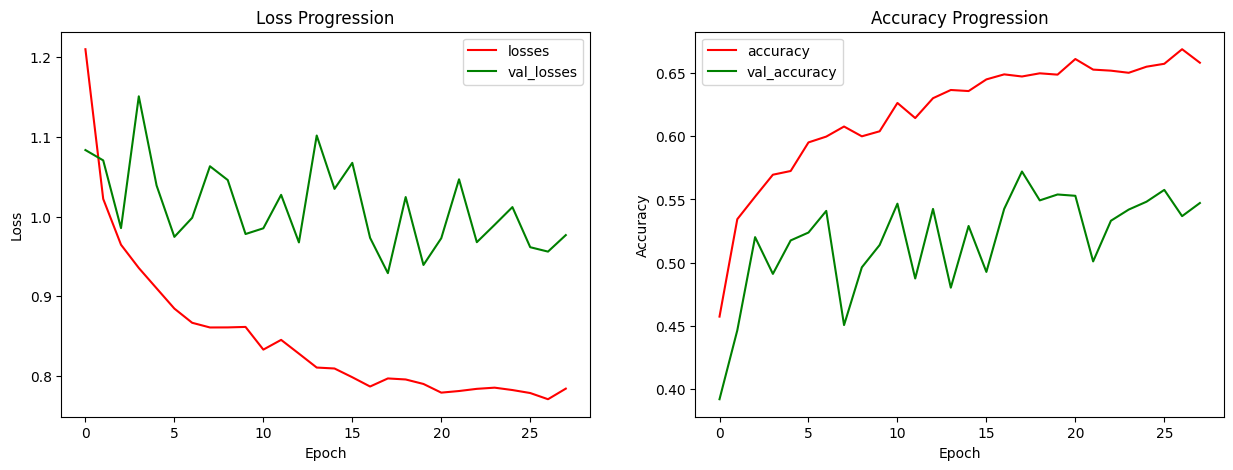

In [ ]:
#plot the training and validation accuracy and losses
num_epochs = len(history.history['loss'])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(range(num_epochs), history.history['loss'], color='red', label='losses')
axes[0].plot(range(num_epochs), history.history['val_loss'], color='green', label='val_losses')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Progression')
axes[0].legend()

axes[1].plot(range(num_epochs), history.history['accuracy'], color='red', label='accuracy')
axes[1].plot(range(num_epochs), history.history['val_accuracy'], color='green', label='val_accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Progression')
axes[1].legend()

plt.show()

In [ ]:
# The result of model.predict has an extra dimension, so we flatten to get a
# vector of predictions.
test_pred_train = np.argmax(model.predict(x_shuffled_train), axis=-1)
print(test_pred_train)

150/150 [==============================] - 1s 6ms/step
[0 2 0 ... 2 2 1]


In [ ]:
# The result of model.predict has an extra dimension, so we flatten to get a
# vector of predictions.
test_pred = np.argmax(model.predict(x_shuffled_val), axis=-1)
print(test_pred)

61/61 [==============================] - 0s 6ms/step
[0 2 2 ... 0 1 1]


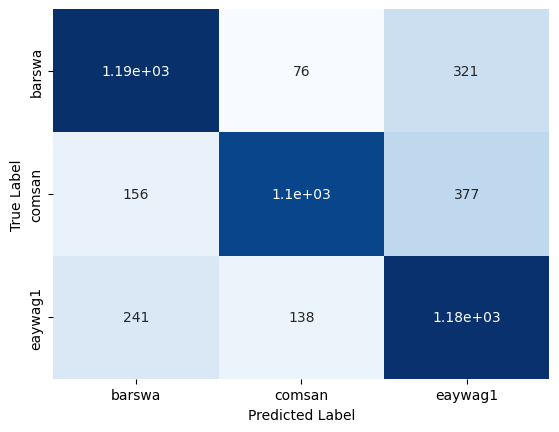

              precision    recall  f1-score   support

           0      0.750     0.750     0.750      1585
           1      0.837     0.674     0.747      1634
           2      0.629     0.757     0.687      1560

    accuracy                          0.726      4779
   macro avg      0.738     0.727     0.728      4779
weighted avg      0.740     0.726     0.728      4779



In [ ]:
#Training accuracy plots
#plot the confusion matrix
class_label = ['barswa',  'comsan',  'eaywag1']

# Create a confusion matrix as a 2D array.
from sklearn import metrics

y_train_1d = np.argmax(y_shuffled_train, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_train_1d, test_pred_train)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_label, yticklabels=class_label, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

#Print the precision, recall and F1-score using metrics from sklearn
print(metrics.classification_report(y_train_1d, test_pred_train, digits=3, zero_division='warn'))

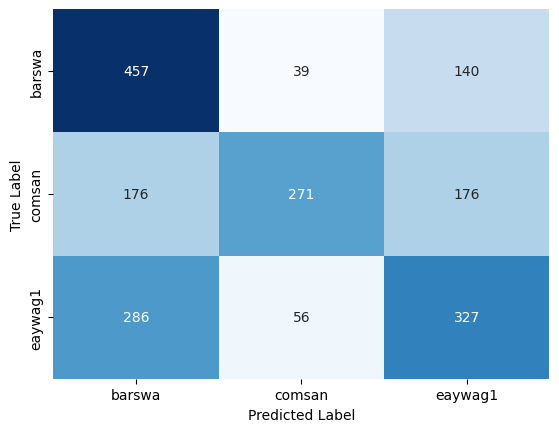

              precision    recall  f1-score   support

           0      0.497     0.719     0.588       636
           1      0.740     0.435     0.548       623
           2      0.509     0.489     0.498       669

    accuracy                          0.547      1928
   macro avg      0.582     0.547     0.545      1928
weighted avg      0.580     0.547     0.544      1928



In [ ]:
#plot the confusion matrix
class_label = ['barswa',  'comsan',  'eaywag1']

# Create a confusion matrix as a 2D array.
from sklearn import metrics

y_val_1d = np.argmax(y_shuffled_val, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_val_1d, test_pred)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=class_label, yticklabels=class_label, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

#Print the precision, recall and F1-score using metrics from sklearn
print(metrics.classification_report(y_val_1d, test_pred, digits=3, zero_division='warn'))

#### Hyperparameter tuning:

| Training accuracy | Validation accuracy | learning rate | optimizer  | gaussian noise (delta) |  pitch shift |  overlaps |
|:-:                |:-:                  |:-:           |:-:       |:-:         |:-:    |:-:          
| 0.59              | 0.51               | 0.01          | SGD    | No       | No          | No       | yes                | 3                | yes            |
| 0.51               | 0.45                 | <font color="red">0.01</font>     | Adam     | No       | No         | yes       | 0.3                | 3                | yes            |
| 0.73               | 0.52                 | 0.002          | <font color="red">SGD</font>  | No     |No           | yes       | 0.3                | 3                | yes,1            |